In [1]:
from KGS import *
import h5py
import scipp as sc
import ipywidgets as ipw

In [2]:



with h5py.File('Pb_phonon_rebinned.hdf5', 'r') as file:
    data_I = file['data/values'][:]
    variances_I = file['data/variances'][:]

    qx = file['coords/elem_000_qx/values'][:]
    qy = file['coords/elem_001_qy/values'][:]
    deltaE = file['coords/elem_002_deltaE/values'][:]

print(np.shape(data_I))

qx = sc.array(dims=["qx"], values=qx, unit="Å^(-1)")
qy = sc.array(dims=["qy"], values=qy, unit="Å^(-1)")
deltaE = sc.array(dims=["deltaE"], values=deltaE, unit="meV")

sliced = sc.DataArray(
    data=sc.array(dims=['qx', 'qy', 'deltaE'], values=data_I, unit="arb. units", variances=variances_I),  #, variances=settings[1]
    coords={"qx": qx, "qy": qy, "deltaE":deltaE}
)

(273, 170, 75)


In [3]:
sliced

<scipp.DataArray>
Dimensions: Sizes[qx:273, qy:170, deltaE:75, ]
Coordinates:
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-0.499815, -0.399819, ..., 6.89986, 6.99985]
* qx                        float64           [1/Å]  (qx [bin-edge])  [-1.95172, -1.93169, ..., 3.49463, 3.51465]
* qy                        float64           [1/Å]  (qy [bin-edge])  [0.409985, 0.429972, ..., 3.78784, 3.80782]
Data:
                            float64      [arb. unit]  (qx, qy, deltaE)  [nan, nan, ..., nan, nan]  [nan, nan, ..., nan, nan]

In [4]:
def to_h(qx):
    a = 4.95
    a_star = 2 * np.pi / a
    return qx / a_star

def to_k(qy):
    a = 4.95
    a_star = 2 * np.pi / a
    return qy / a_star

graph = {'h': to_h}
graph2 = {'k': to_k}

transformed = sliced.transform_coords(['h'], graph=graph)
sliced = transformed.transform_coords(['k'], graph=graph2)

In [5]:
sliced

<scipp.DataArray>
Dimensions: Sizes[h:273, k:170, deltaE:75, ]
Coordinates:
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-0.499815, -0.399819, ..., 6.89986, 6.99985]
* h                         float64           [1/Å]  (h [bin-edge])  [-1.5376, -1.52182, ..., 2.75313, 2.7689]
* k                         float64           [1/Å]  (k [bin-edge])  [0.322993, 0.338739, ..., 2.98412, 2.99987]
  qx                        float64           [1/Å]  (h [bin-edge])  [-1.95172, -1.93169, ..., 3.49463, 3.51465]
  qy                        float64           [1/Å]  (k [bin-edge])  [0.409985, 0.429972, ..., 3.78784, 3.80782]
Data:
                            float64      [arb. unit]  (h, k, deltaE)  [nan, nan, ..., nan, nan]  [nan, nan, ..., nan, nan]

In [6]:
E_min = -0.05 * sc.Unit('meV')
E_max = 7.0 * sc.Unit('meV')


def update_plot_qyE(amp):
    k_layer = amp * sc.Unit('Å^(-1)')
    plt.figure(figsize=(6,4))
    p1 = sliced['k', k_layer]['deltaE', E_min:E_max].transpose()#.plot(cmap='jet')
    im = plt.pcolormesh(p1.coords['h'].values, p1.coords['deltaE'].values, p1.values, cmap='jet', vmin=0, vmax=0.0001)
    cbar = plt.colorbar(im)
    cbar.set_label('I [a.u.]')
    plt.xlim(-2,2)
    plt.ylim(0,7)
    plt.xlabel('$h$ [r.l.u]')
    plt.ylabel('$\Delta E$ [meV]')
    plt.title(f"$k =$ {amp:.2f} [r.l.u]")
    plt.savefig('Pb_phonon_BIFROST_hk.pdf', format='pdf', bbox_inches='tight')
    

w_qyE = ipw.FloatSlider( 
    value=2,
    min=min(sliced.coords['k'].values),
    max=4,
    step=(sliced.coords['k'].values[1]-sliced.coords['k'].values[0]),
    description="k:",
    disabled=False,
    continuous_update=True,
    orientation="horizontal",
    readout=True,
    readout_format=".2f",
)
# Display the slider


ipw.interactive(update_plot_qyE, amp=w_qyE)

interactive(children=(FloatSlider(value=2.0, description='k:', max=4.0, min=0.322993139750477, step=0.01574632…

In [7]:
E_min = -2 * sc.Unit('meV')
E_max = 10 * sc.Unit('meV')

k_layer = 2 * sc.Unit('Å^(-1)')

p1 = sliced['k', k_layer]['deltaE', E_min:E_max].transpose()
p1

<scipp.DataArray>
Dimensions: Sizes[deltaE:75, h:273, ]
Coordinates:
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-0.499815, -0.399819, ..., 6.89986, 6.99985]
* h                         float64           [1/Å]  (h [bin-edge])  [-1.5376, -1.52182, ..., 2.75313, 2.7689]
  k                         float64           [1/Å]  (k [bin-edge])  [1.9921, 2.00785]
  qx                        float64           [1/Å]  (h [bin-edge])  [-1.95172, -1.93169, ..., 3.49463, 3.51465]
  qy                        float64           [1/Å]  (k [bin-edge])  [2.52864, 2.54862]
Data:
                            float64      [arb. unit]  (deltaE, h)  [nan, nan, ..., nan, nan]  [nan, nan, ..., nan, nan]

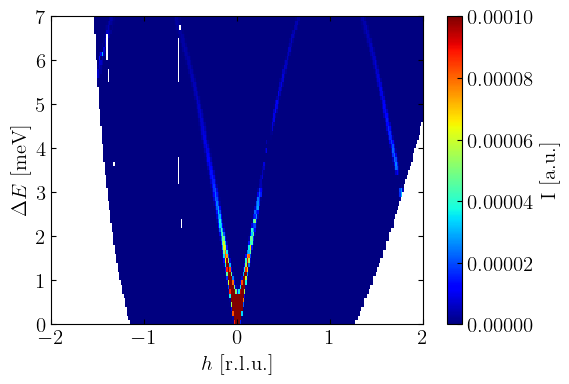

In [8]:

fig, ax = plt.subplots(1,1,figsize=(6,4))
im = ax.pcolormesh(p1.coords['h'].values, p1.coords['deltaE'].values, p1.values, cmap='jet', vmin=0, vmax=0.0001) # norm=colors.LogNorm()
cbar = plt.colorbar(im)
cbar.set_label('I [a.u.]')
ax.set_xlim(-2,2)
ax.set_ylim(0,7)
ax.set_xlabel('$h$ [r.l.u.]')
ax.set_ylabel('$\Delta E$ [meV]')


# vertices5 = [(-0.21, 1), (-0.19, 1), (-0.19, 3),(-0.21, 3)]
# parallelogram5 = Polygon(vertices5, closed=True, edgecolor='#7570b3', facecolor='none')
# ax.add_patch(parallelogram5)
# 
# vertices6 = [(0.21, 1), (0.19, 1), (0.19, 3),(0.21, 3)]
# parallelogram6 = Polygon(vertices6, closed=True, edgecolor='#d95f02', facecolor='none')
# ax.add_patch(parallelogram6)
# 
# vertices6 = [(0.5, 1.8), (-0.5, 1.8), (-0.5, 2.2),(0.5, 2.2)]
# parallelogram6 = Polygon(vertices6, closed=True, edgecolor='#1b9e77', facecolor='none')
# ax.add_patch(parallelogram6)

plt.savefig('Pb_phonon_fit.pdf', format='pdf', bbox_inches='tight')

{'peak_heights': array([4.67857143e-06])}
Given names not corresponding to function, overwriting...
<ValueView A0=4.792820610988682e-06 mu0=5.78187090963462 sigma0=0.13949458476770968>
{'peak_heights': array([5.33333333e-06])}
Given names not corresponding to function, overwriting...
<ValueView A0=5.333333333333335e-06 mu0=5.34992682 sigma0=0.1>
{'peak_heights': array([7.03125e-06])}
Given names not corresponding to function, overwriting...
<ValueView A0=7.2036268366041195e-06 mu0=4.717710475475115 sigma0=0.1917710696591675>
{'peak_heights': array([9.29032258e-06])}
Given names not corresponding to function, overwriting...
<ValueView A0=9.315103006689592e-06 mu0=4.213849027628906 sigma0=0.19498041493657303>
{'peak_heights': array([1.26363636e-05])}
Given names not corresponding to function, overwriting...
<ValueView A0=1.3412462700984384e-05 mu0=3.660202582321843 sigma0=0.16960724875766348>
{'peak_heights': array([1.76444444e-05])}
Given names not corresponding to function, overwriting

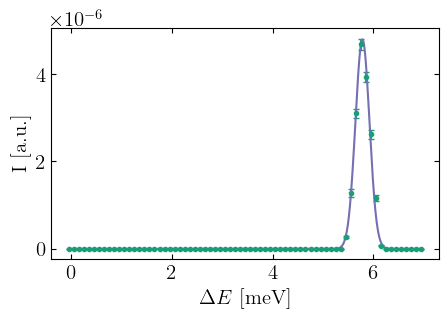

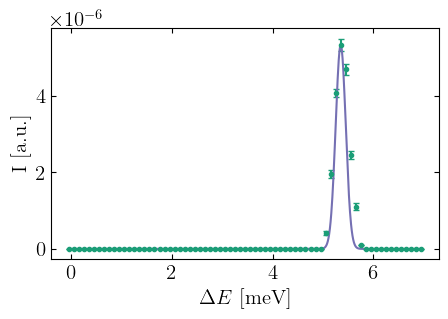

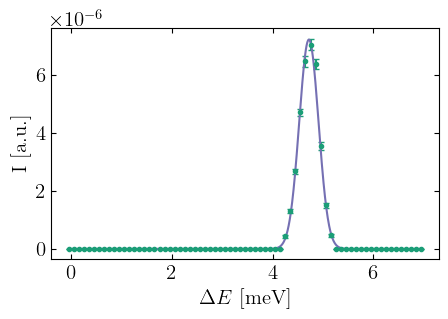

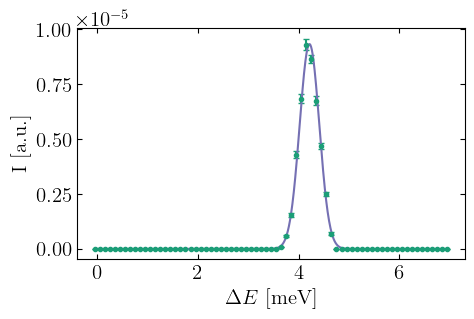

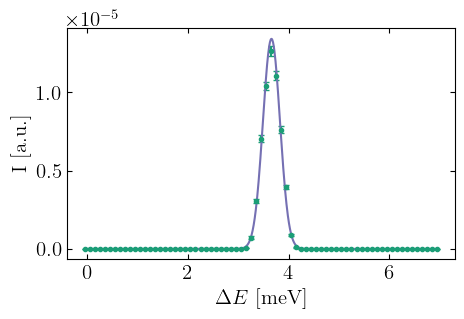

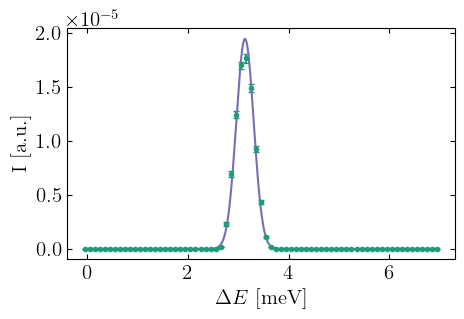

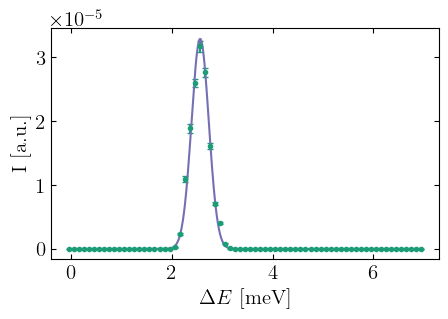

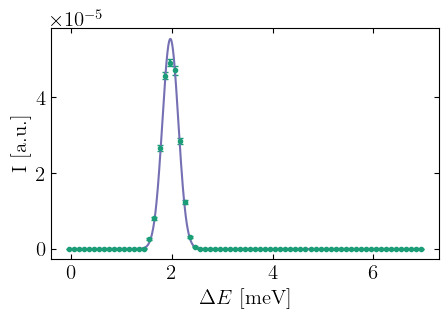

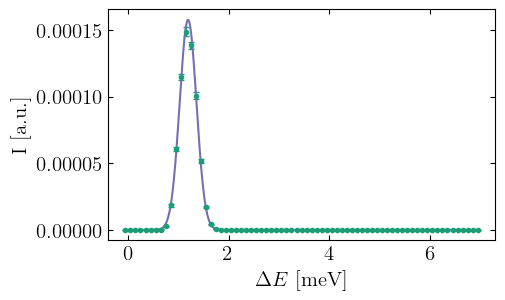

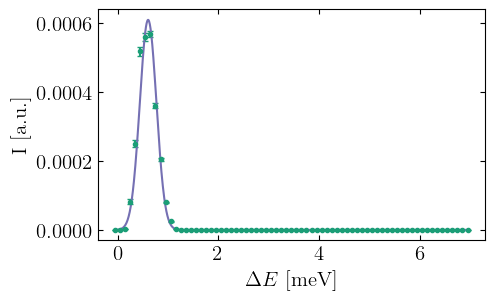

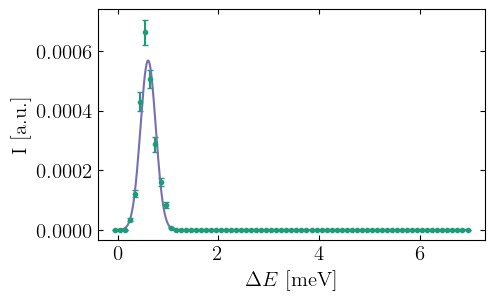

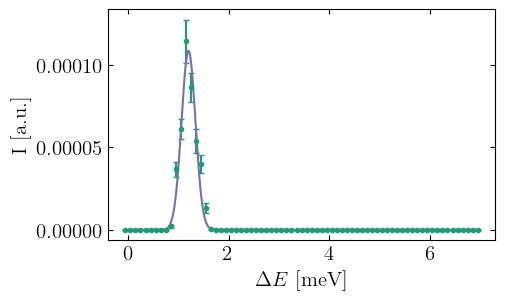

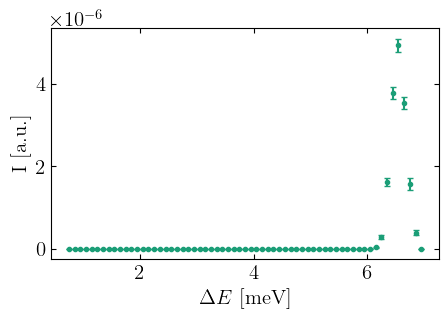

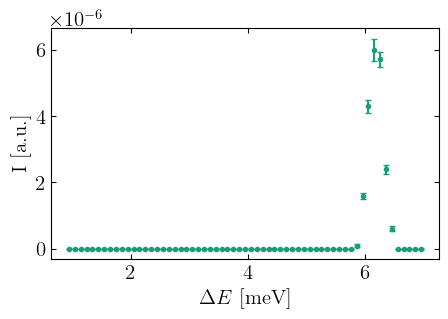

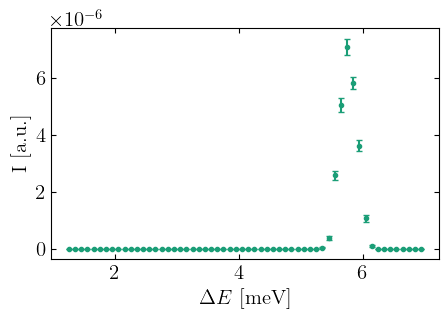

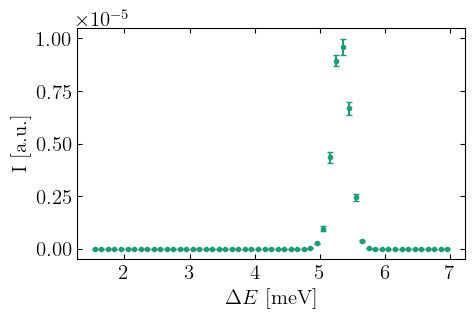

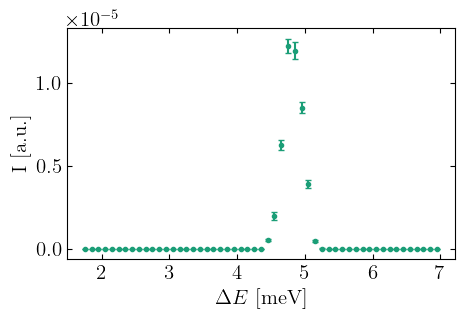

In [117]:
from scipy.signal import find_peaks


hsteps = np.array([-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0.05, 0.1 ,1.4, 1.45, 1.5, 1.55, 1.6])

E_ax = []
I = []
I_err = []

#fig, axs = plt.subplots(1, 8, figsize=(20, 3))

for i in range(len(hsteps)):
    h_layer = hsteps[i] * sc.Unit('Å^(-1)')
    E_min = 0 * sc.Unit('meV')
    E_max = 7 * sc.Unit('meV')

    p2 = p1['deltaE', E_min:E_max]['h',h_layer]
    E = p2.coords['deltaE'].values
    E = (E[:-1] + E[1:]) / 2.0
    I.append(p2.values)
    I_err.append(p2.variances)
    E_ax.append(E)
    
    plt.figure(figsize=(5, 3))
    plt.errorbar(E, p2.values, np.sqrt(p2.variances), fmt='.')  
    plt.xlabel("$\Delta E$ [meV]")
    plt.ylabel("I [a.u.]")
    
    peaks, height = find_peaks(p2.values, height=max(p2.values))  # Adjust parameters as needed
    
    print(height)

    peak_parameters = {}
    fit_params = []
    fit_errors = []

    for j, peak in enumerate(peaks):
        peak_parameters[f'dataset_{i+1}_peak_{j+1}'] = {
            f'A{j}': height['peak_heights'][j],
            f'mu{j}': E[peaks][j],
            f'sigma{j}':0.1}
   

        fitting = fit(E, p2.values, np.sqrt(p2.variances), gauss, peak_parameters[f'dataset_{i+1}_peak_{j+1}'])
        #print(fitting.values)
        fit_params.append(fitting.values)
        fit_errors.append(fitting.errors)

        print(fitting.values)
        E_range = np.linspace(min(E), max(E), 1000)
        plt.plot(E_range, gauss(E_range, *fitting.values))
    
    
